In [1]:
# silencing some logs/warning
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
%env WANDB_SILENT=True

import os
import sys
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import wandb

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from process_data import process_data
from evaluate import evaluate_pred, print_dummy_evaluations
from visualization import plot_confusion_matrix
from utils.constants import SEED

env: WANDB_SILENT=True


In [2]:
wandb.login()

True

# Get data

In [3]:
split_prec = {
    'train': 0.7, 
    'valid': 0.15, 
    'test': 0.15
}
scaler = None

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = process_data(split_prec, scaler)

columns = X_train.columns.to_list()

Dropped columns: ['day_of_week' 'month' 'snow']
New columns: ['day_0' 'day_1' 'day_2' 'day_3' 'day_4' 'day_5' 'day_6' 'month_1'
 'month_10' 'month_11' 'month_12' 'month_2' 'month_3' 'month_4' 'month_5'
 'month_6' 'month_7' 'month_8' 'month_9' 'temp_fahrenheit']
Split: "train" 	[Size: 1120] 	[Prec: 0.7]
	X: (1120, 32)
	Y: (1120,)
Split: "valid" 	[Size: 239] 	[Prec: 0.149375]
	X: (239, 32)
	Y: (239,)
Split: "test" 	[Size: 241] 	[Prec: 0.150625]
	X: (241, 32)
	Y: (241,)


# Hyperparameter Optimization
1. Set up configuration (possible values)
2. Run optimization
3. Get best parameters

In [4]:
## 1. Set up configuration

PROJECT_NAME = 'SML'
PROJECT_ENTITY = 'daniel-veress'

GOAL_METRIC = 'accuracy'
NUMBER_OF_RUNS = 200
sweep_configuration = {
    'method': 'bayes',
    'metric': {'goal': 'maximize', 'name': GOAL_METRIC},
    'parameters': {
        'eta': {'max': 1.0, 'min': 0.0},
        'gamma': {'max': 10.0, 'min': 0.0},
        'max_depth': {'max': 12, 'min': 1},
        'min_child_weight': {'max': 10.0, 'min': 0.0},
        'max_delta_step': {'max': 20, 'min': 0},
        'subsample': {'max': 1.0, 'min': 0.1},
        'lambda': {'max': 3.0, 'min': 0.0},
        'alpha': {'max': 3.0, 'min': 0.0},
        'tree_method': {'values': ['auto', 'exact', 'approx', 'hist']},
        'scale_pos_weight': {'max': 2.0, 'min': 0.0},
    }
}

sweep_id = wandb.sweep(
    project=PROJECT_NAME,
    sweep=sweep_configuration
)

Create sweep with ID: jpiy99k5
Sweep URL: https://wandb.ai/daniel-veress/SML/sweeps/jpiy99k5


In [5]:
## 2. Run optimization

def objective(config):
    # creating the model
    early_stop = xgb.callback.EarlyStopping(
        rounds=2, metric_name='logloss', data_name='validation_0', save_best=True
    )
    model = XGBClassifier(
        eta=config['eta'],
        gamma=config['gamma'],
        max_depth=config['max_depth'],
        min_child_weight=config['min_child_weight'],
        max_delta_step=config['max_delta_step'],
        subsample=config['subsample'],
        reg_lambda=config['lambda'],
        alpha=config['alpha'],
        tree_method=config['tree_method'],
        scale_pos_weight=config['scale_pos_weight'],
        callbacks=[early_stop],
        random_state=SEED
    )

    # training
    model.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])
    
    # evaluating
    y_pred = model.predict(X_valid)
    y_true = Y_valid
    metrics = evaluate_pred(y_pred, y_true)
    return metrics

def main():
    run = wandb.init(
      project=PROJECT_NAME,
      config={
          'splits': split_prec,
          'scaler': scaler,
          'columns': columns
      }
    )
    metrics = objective(wandb.config)
    wandb.log(metrics)


# start sweeping/optimization
wandb.agent(sweep_id, function=main, count=NUMBER_OF_RUNS)
wandb.finish()

[0]	validation_0-logloss:0.39290
[1]	validation_0-logloss:0.32415
[2]	validation_0-logloss:0.30671
[3]	validation_0-logloss:0.31535
[0]	validation_0-logloss:0.50979
[1]	validation_0-logloss:0.52617
[2]	validation_0-logloss:0.54372
[0]	validation_0-logloss:0.33282
[1]	validation_0-logloss:0.32699
[2]	validation_0-logloss:0.31731
[3]	validation_0-logloss:0.30368
[4]	validation_0-logloss:0.28368
[5]	validation_0-logloss:0.26883
[6]	validation_0-logloss:0.27276
[0]	validation_0-logloss:0.39097
[1]	validation_0-logloss:0.33024
[2]	validation_0-logloss:0.31474
[3]	validation_0-logloss:0.28677
[4]	validation_0-logloss:0.28745
[5]	validation_0-logloss:0.28333
[6]	validation_0-logloss:0.27968
[7]	validation_0-logloss:0.27720
[8]	validation_0-logloss:0.27720
[9]	validation_0-logloss:0.27720
[0]	validation_0-logloss:0.49447
[1]	validation_0-logloss:0.46648
[2]	validation_0-logloss:0.43488
[3]	validation_0-logloss:0.44901
[4]	validation_0-logloss:0.42036
[5]	validation_0-logloss:0.43221
[6]	valida

In [7]:
## 3. Get best parameters/run
api = wandb.Api()
sweep = api.sweep(f'{PROJECT_ENTITY}/{PROJECT_NAME}/sweeps/{sweep_id}')
best_run = sweep.best_run(order=GOAL_METRIC)

print('Best hyperparameters:')
best_parameters = best_run.config
non_model_parameters = ['scaler', 'splits', 'columns']
hyperparameters = {}
for param, value in best_parameters.items():
    print(f'{param}: {value}')
    # correct parameters, so only model hyperparameters are included
    if param not in non_model_parameters:
        hyperparameters[param] = value

print('\nMetrics:')
best_metrics = best_run.summary
for param, value in best_metrics.items():
    if '_' != param[0]:
        print(f'{param:<10}: {value}')

Best hyperparameters:
eta: 0.26409494152220203
alpha: 1.2001248019173314
gamma: 0.8261538735795615
lambda: 0.0783942481937131
scaler: None
splits: {'test': 0.15, 'train': 0.7, 'valid': 0.15}
columns: ['hour_of_day', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_fahrenheit']
max_depth: 6
subsample: 0.7073101564589653
tree_method: exact
max_delta_step: 2
min_child_weight: 6.154424875936314
scale_pos_weight: 1.5501724473483611

Metrics:
accuracy  : 0.9205020920502092
precision : 0.7954545454545454
recall    : 0.7777777777777778


# Training

In [8]:
early_stop = xgb.callback.EarlyStopping(
    rounds=2, metric_name='logloss', data_name='validation_0', save_best=True
)
model = XGBClassifier(
    **hyperparameters,
    callbacks=[early_stop],
    random_state=SEED
)

#model = GradientBoostingClassifier(**hyperparameters, random_state=SEED)
model.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])

[0]	validation_0-logloss:0.42616
[1]	validation_0-logloss:0.36320
[2]	validation_0-logloss:0.32671
[3]	validation_0-logloss:0.30264
[4]	validation_0-logloss:0.28403
[5]	validation_0-logloss:0.27816
[6]	validation_0-logloss:0.26621
[7]	validation_0-logloss:0.26122
[8]	validation_0-logloss:0.25635
[9]	validation_0-logloss:0.24649
[10]	validation_0-logloss:0.24148
[11]	validation_0-logloss:0.23546
[12]	validation_0-logloss:0.23075
[13]	validation_0-logloss:0.22887
[14]	validation_0-logloss:0.22704
[15]	validation_0-logloss:0.22340
[16]	validation_0-logloss:0.22094
[17]	validation_0-logloss:0.22470


XGBClassifier(alpha=1.2001248019173314, base_score=None, booster=None,
              callbacks=[<xgboost.callback.EarlyStopping object at 0x79e909fb2d90>],
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.26409494152220203,
              eval_metric=None, feature_types=None, gamma=0.8261538735795615,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0783942481937131,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=2, max_depth=6,
              max_leaves=None, min_child_weight=6.154424875936314, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

# Evaluating

In [9]:
y_pred = model.predict(X_test)
y_true = Y_test

metrics = evaluate_pred(y_pred, y_true)

print('-- Boosting model --\n')
for metric, value in metrics.items():
    print(f'{metric.capitalize()}: \t{value}')

print('\n-- Dummy models -- ')
print_dummy_evaluations(X_train, Y_train, X_test, Y_test)

-- Boosting model --

Accuracy: 	0.8755186721991701
Recall: 	0.6111111111111112
Precision: 	0.5789473684210527

-- Dummy models -- 

Most_frequent
  Accuracy: 	0.8506224066390041
  Recall: 	0.0
  Precision: 	0.0

Stratified
  Accuracy: 	0.7053941908713693
  Recall: 	0.16666666666666666
  Precision: 	0.1276595744680851

Uniform
  Accuracy: 	0.4315352697095436
  Recall: 	0.3333333333333333
  Precision: 	0.096


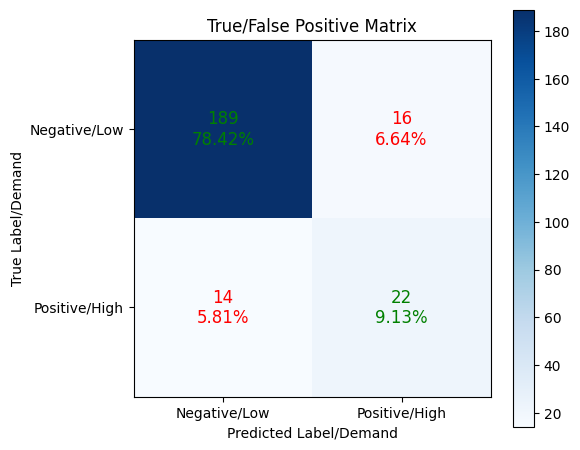

True Positive (TP): 22
True Negative (TN): 189
False Positive (FP): 16
False Negative (FN): 14


In [10]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
confusion_matrix_data = np.array([[tn, fp], [fn, tp]])
plot_confusion_matrix(confusion_matrix_data)

print(f'True Positive (TP): {tp}')
print(f'True Negative (TN): {tn}')
print(f'False Positive (FP): {fp}')
print(f'False Negative (FN): {fn}')